# This notebook is prepared by ApplAi's Technical And Training Depratment. 
- Please Don't use it outside the training without asking for permission as it's considered as Violation of Intellectual property rights

![ApplAi's Logo](https://media-exp1.licdn.com/dms/image/C4E0BAQHGLGltI2rzuQ/company-logo_200_200/0?e=2159024400&v=beta&t=adq8rNV09dPC6egdJMnfARt6Aq0TC9bSomFvFtm50WM)

### Task 1: Importing libraries and Exploring the Dataset.

### Task 2: Definining Exploratory Data Analysis with an overview of the whole project .

### Task 3: Checking missing values and Outliers & Creating visual methods to analyze the data.

### Task 4: creat a model that fits the data

### Task 5: creating an accurecy table


### 

### Task 1: Importing libraries and Exploring the Dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as ex
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib

### Task 2: Definining Exploratory Data Analysis with an overview of the whole project 

In [2]:
df = pd.read_csv('Mall_Customers.csv')

In [3]:
df.info() # Learning the structure of the data available


# Also there is no Null values in the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# **Checking the data for Null values and Outliers**

In [4]:
for i, col in enumerate(df.loc[:, df.columns != 'Gender']):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = 1.5 * (Q3 - Q1)
  UO = df[df[col] > IQR + Q3].count() / df[col].count() * 100
  LO = df[df[col] < Q1 - IQR].count() / df[col].count() * 100
  print(col,": ", df[col].isna().sum() / df[col].count() * 100, LO[col], UO[col])
  
#OUTPUT READ LIKE -> Column Name - Number of null values - Percent of lower outliers - Percent of upper outliers 
# Only one percent upper outlier in the Age column, and once again we confirm that there are no Null values in the data

CustomerID :  0.0 0.0 0.0
Age :  0.0 0.0 0.0
Annual Income (k$) :  0.0 0.0 1.0
Spending Score (1-100) :  0.0 0.0 0.0


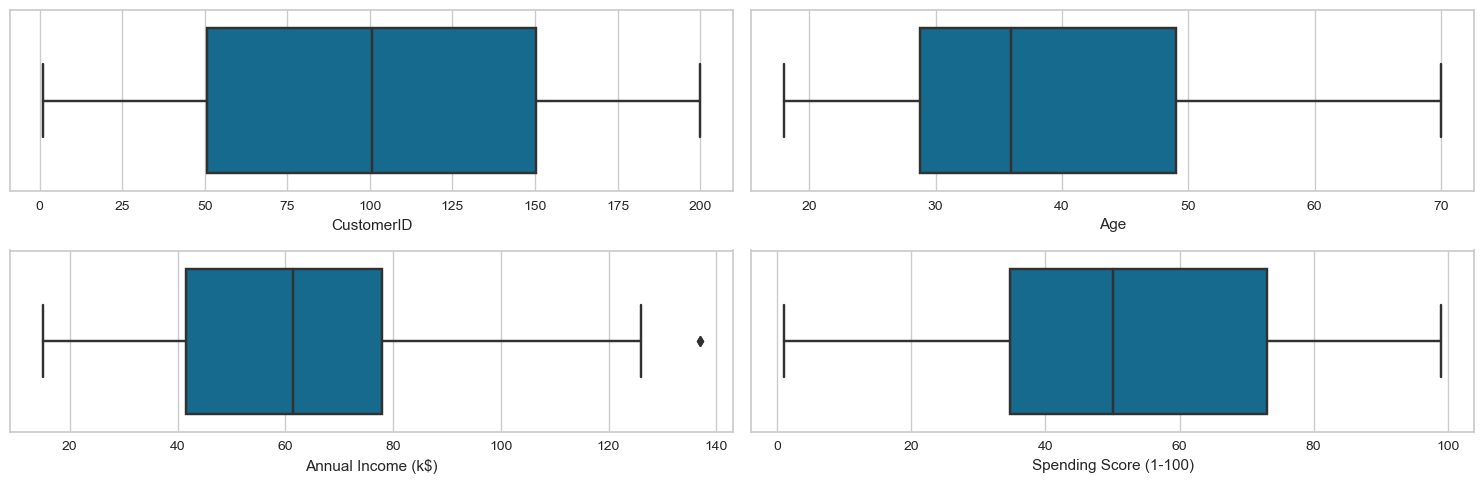

In [5]:
# Set dimension of output figure
cols = 2
rows = 2
fig = plt.figure(figsize= (15,5))

# Loop through the columns to print out each boxplot
for i, col in enumerate(df.loc[:, df.columns != 'Gender']):
    
    ax=fig.add_subplot( rows, cols, i+1)
    
    sns.boxplot(x=df[col], ax=ax)
    
fig.tight_layout()  
plt.show()
# Again we can witness the Outlier here as well, but we can neglect it for triviality 

# **After dealing with data outliers and null values, We check the general behaviour of the data, and check for any patterns or relations between features**

<AxesSubplot:>

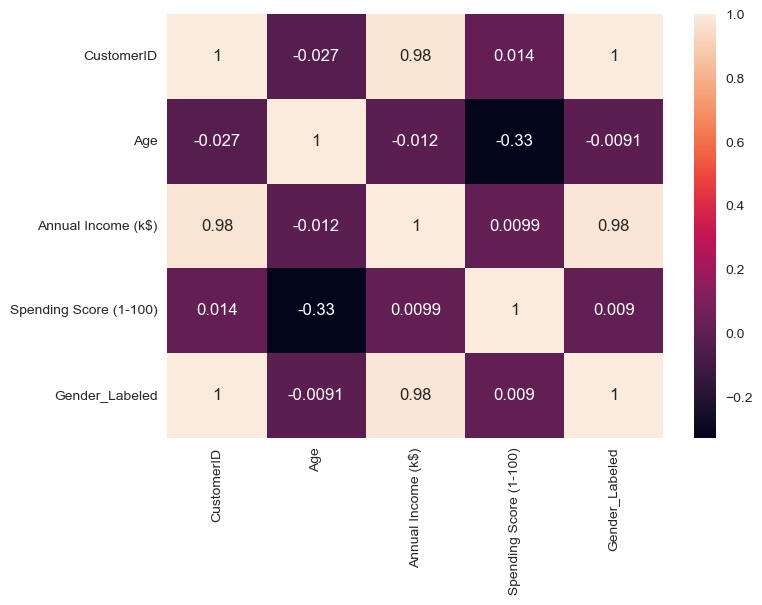

In [6]:
df['Gender_Labeled'] = df['Annual Income (k$)'].astype('category').cat.codes
sns.heatmap(df.corr(),annot=True)

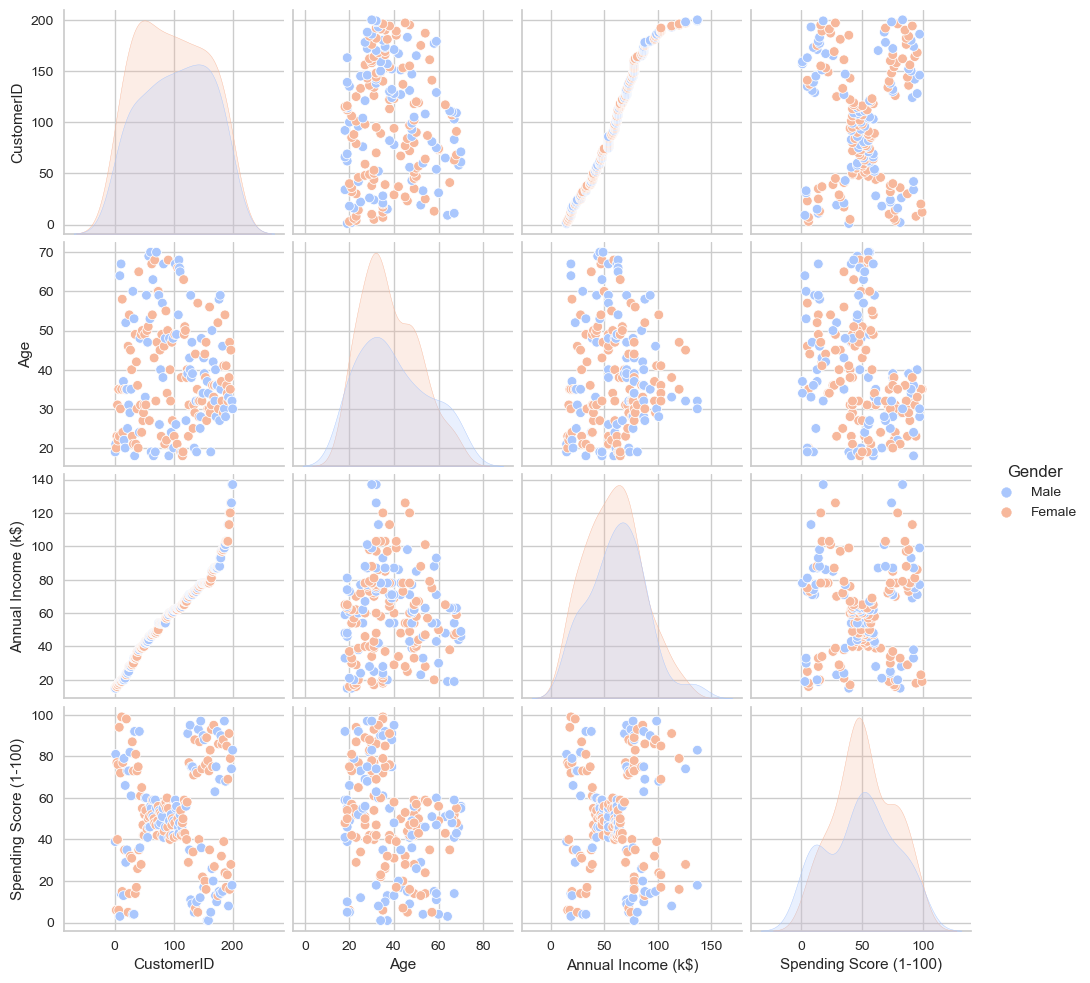

In [7]:
sns.pairplot(df.loc[:, df.columns != "Gender_Labeled"],hue='Gender',palette='coolwarm')

# From prior graphs one can conclude, that although in our dataset the people above the age of 50 are women, and that women have a higher peak of income than men, it still seems that the data is evenly distributed between the 2 genders
.....................................................................

# Also from the heat map there is no colleration between our features
.....................................................................
# And finally the income of the customer cannot possibly depend on ther id (ILLOGICAL)

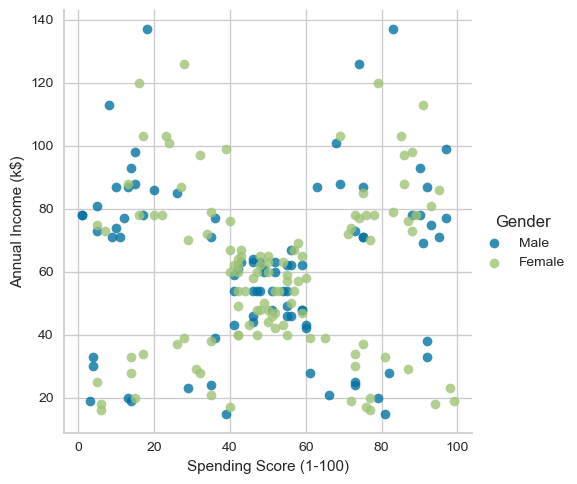

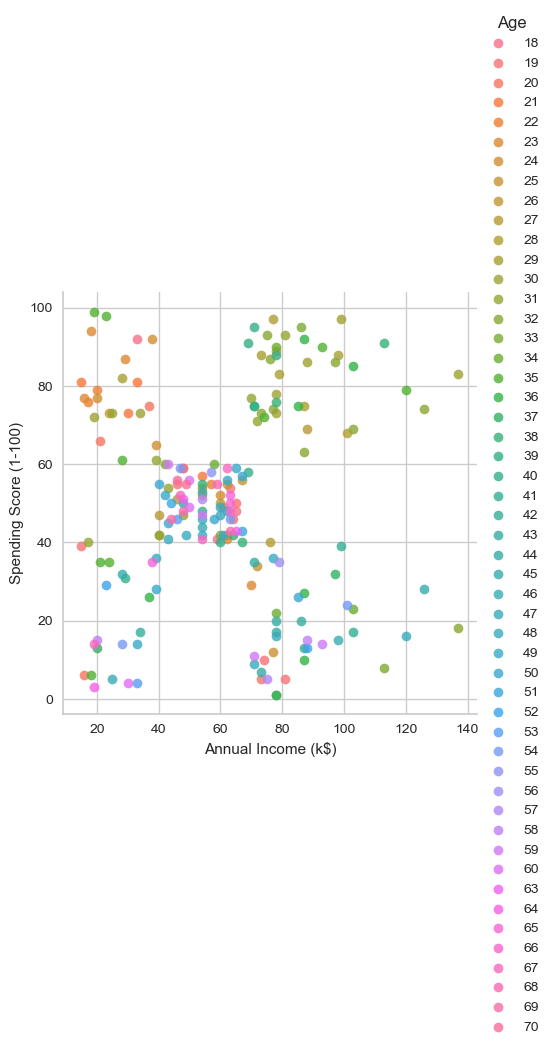

In [8]:
# Redrawing Graphs of interest on a Larger scale to futher study them

sns.lmplot(x='Spending Score (1-100)', y='Annual Income (k$)', data=df, hue='Gender', fit_reg=False)
sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue='Age', fit_reg=False)

**It is quite clear from the graph that the data points are almost evenly distributed between male and female.
which means it is not a factor of how much income a person makes or their spending score.**

**It is also clear from the data that age also doesn't have a direct relation to the income or the spending score.
One could argue that the cluster of high income and high spending score consists almost exclusively of humans in their 30's
But such relation doesn't hold for all cluster, rendering it Meaningless.**

------------------------------------

# **Thus one concludes that the only features worth of study and analysis for our model are the (Annual income) and the (Spending Score)**

# ------------------------------------------------------------------------------

After studying the data, unsupervised learning models were chosen, due to the need to group customers in clusters of similar behaviours, especially to target high income/ low spending score customers.

Due to the shape of the data and how spread out it is, and the varying density of the clusters, Kmeans was selected as the prefered model of choice.

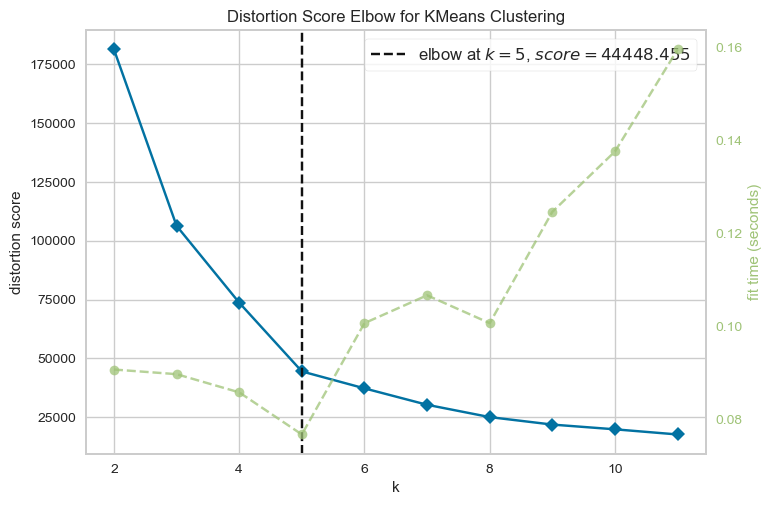

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# From the previous graphs it is obvious the data should be split into 5 clusters, but we are gonna use the elbow method to test our hypothesis
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

# Using a library to accurately calculate the value of K
visualizer.fit(df[['Annual Income (k$)','Spending Score (1-100)']])
visualizer.show()

# After Plotting the error against the number of clusters, it is apparent using the elbow method that 5 is indeed the prefered number of clusters.

Silhouette Score:  0.553931997444648


<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

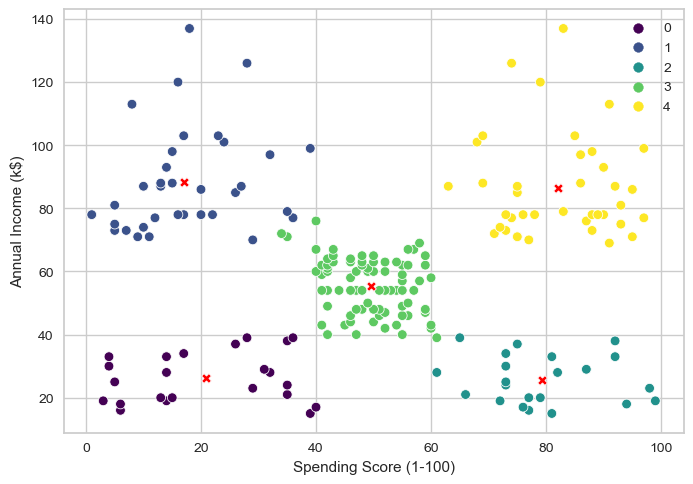

In [10]:
# Using K as 5 and a number of initilization equal to 20
kmeans = KMeans(n_clusters=5, init='random',n_init=20, max_iter=300,random_state=0)
y_predicted = kmeans.fit_predict(df[['Spending Score (1-100)','Annual Income (k$)']])
df['Clusters'] = kmeans.labels_
print("Silhouette Score: ", metrics.silhouette_score(df[['Annual Income (k$)','Spending Score (1-100)']], kmeans.labels_))

# Getting the centers of the clusters
Centers = kmeans.cluster_centers_
fig2 = ex.scatter(df, x="Spending Score (1-100)", y="Annual Income (k$)", color="Clusters",
                 title="Cluster Distribution")
fig2.add_traces(go.Scatter(x=Centers[:,0], y=Centers[:,1], mode="markers",
                marker=dict(size=12,line=dict(width=2,color='DarkSlateGrey')),showlegend=False))


# Graphing the Results
sns.scatterplot(x="Spending Score (1-100)", y="Annual Income (k$)",hue = 'Clusters',  data=df,palette='viridis')
sns.scatterplot(x=Centers[:,0], y=Centers[:,1], marker='X', color='red')

#print(Centers)


# Accuracy of 0.55, Silhouetter Score varies between -1 and 1, the greater the number the better the clustering.

In [15]:
# Portray Clusters in a more understandable Graphical manner

X = []
for i in range(5):
  X.append(df[df['Clusters'] == i].count()[0])

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "domain"}]])
fig.update_layout(bargap=0.2)

fig.add_trace(go.Histogram(x=df["Clusters"],showlegend=False)  , row=1, col=1)

fig.add_trace(go.Pie(values=X)  , row=1, col=2)


This is the final chart of the data, The data is now split into 5 clusters to fit the model, since the model is unsupervised .

**If more data was available one could further assign attributes to each cluster, like (hobbies, fav drink, etc..)
as of now with the current data one can conclude: **

**Cluseter 0: The Purple cluster, repersents people with low income and low spending score at the mall, they do not and can not contribute much to the income of the mall, therefore not a primary target.**

**Cluster 1: The Dark Blue cluster, represents people with high income and low spending score, they do not but can contribute with a big sum of money to the mall, therefore they are a primary target, we should focus ads on them, and offer them convenience.**

**Cluster 2: The Dark Green cluster, represents people with low income and high spending score, they are people that frequent the mall, and contribute to our income, with how high their spending score is compared to their income, they must be usual customres to the mall, they are an important target and should be satisfied.**

**Cluster 3: The Light Green cluster, represents people with mid income and mid spending score, they are people that could be frequent customers or buy semi-expensive items occasionaly causing a medimum spending score, they have the potenial to spend more, and therefore contribute even more the mall's income, therefore they should be cared for and provided convenience.**

**Cluster 4: The Yellow cluster, represents people with high income and high spending scores, they are the most important customers to our mall, they contribute the biggest amount of our income, they are the most important target as they are frequent customers that we can not lose, we must offer them convenience and satisfaction.**



# Now we will compare between the Kmeans method and DBscan, to check which is higher in accuracy


In [12]:
x = df.loc[:, ['Spending Score (1-100)','Annual Income (k$)']].values
dbscan = DBSCAN(eps = 8, min_samples = 3).fit(x)
labels = dbscan.labels_
print("Silhouette Score: ",metrics.silhouette_score(df[['Annual Income (k$)','Spending Score (1-100)']], labels))
# Accuracy of 0.45, less than Kmeans

Silhouette Score:  0.4466832173019108


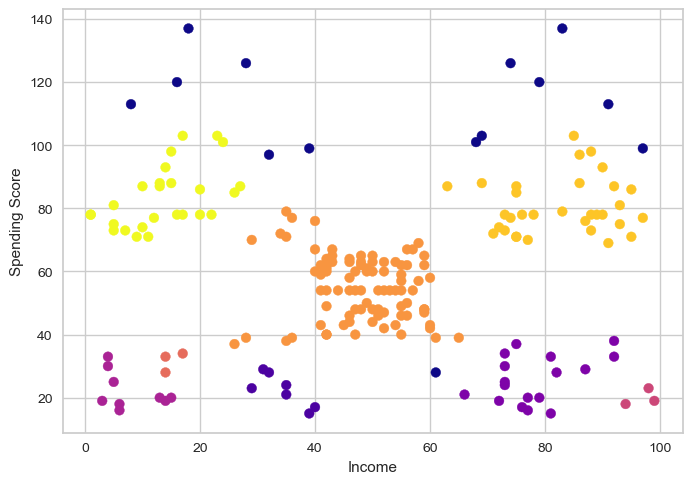

In [13]:
plt.scatter(x[:, 0], x[:,1], c = labels, cmap= "plasma")
plt.xlabel("Income")
plt.ylabel("Spending Score") 
plt.show()

# **Clearly Kmeans is more suited for this structure of data**

In [16]:
data = [Centers,fig,fig2]
joblib_file = "Customer_Segmentation_model"
joblib.dump(data, joblib_file)




['Customer_Segmentation_model']